Here's a notebook that walks through the process the `Blob_survey` class takes in constructing a list of observations to be executed. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler
from lsst.sims.featureScheduler.utils import standard_goals, calc_norm_factor
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (generate_dd_surveys, Greedy_survey,
                                                Blob_survey)
from lsst.sims.featureScheduler import sim_runner

from lsst.sims.featureScheduler.utils import (int_binned_stat,
                                              gnomonic_project_toxy, tsp_convex)
from lsst.sims.utils import _angularSeparation, _hpid2RaDec, _approx_RaDec2AltAz


In [2]:
# Taking a large chunk of code from https://github.com/lsst-sims/sims_featureScheduler_runs/blob/master/baselines/baselines.py
# to setup a basic scheduler
def gen_greedy_surveys(nside, nexp=1):
    """
    Make a quick set of greedy surveys
    """
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)
    # Let's remove the bluer filters since this should only be near twilight
    filters = ['r', 'i', 'z', 'y']
    surveys = []

    for filtername in filters:
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=40.))
        bfs.append(bf.Clouded_out_basis_function())

        bfs.append(bf.Filter_loaded_basis_function(filternames=filtername))

        weights = np.array([3.0, 0.3, 3., 3., 0., 0., 0., 0.])
        surveys.append(Greedy_survey(bfs, weights, block_size=1, filtername=filtername,
                                     dither=True, nside=nside, ignore_obs='DD', nexp=nexp))

    return surveys


def generate_blobs(nside, mixed_pairs=False, nexp=1, no_pairs=False):
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)

    # List to hold all the surveys (for easy plotting later)
    surveys = []

    # Set up observations to be taken in blocks
    filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
    if mixed_pairs:
        filter2s = [None, 'r', 'i', 'z', None, None]
    else:
        filter2s = [None, 'g', 'r', 'i', None, None]

    if no_pairs:
        filter2s = [None, None, None, None, None, None]

    # Ideal time between taking pairs
    pair_time = 22.
    times_needed = [pair_time, pair_time*2]
    for filtername, filtername2 in zip(filter1s, filter2s):
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        if filtername2 is not None:
            bfs.append(bf.M5_diff_basis_function(filtername=filtername2, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        if filtername2 is not None:
            bfs.append(bf.Target_map_basis_function(filtername=filtername2,
                                                    target_map=target_map[filtername2],
                                                    out_of_bounds_val=np.nan, nside=nside,
                                                    norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=30.))
        bfs.append(bf.Clouded_out_basis_function())
        filternames = [fn for fn in [filtername, filtername2] if fn is not None]
        bfs.append(bf.Filter_loaded_basis_function(filternames=filternames))
        if filtername2 is None:
            time_needed = times_needed[0]
        else:
            time_needed = times_needed[1]
        bfs.append(bf.Time_to_twilight_basis_function(time_needed=time_needed))
        bfs.append(bf.Not_twilight_basis_function())
        weights = np.array([3.0, 3.0, .3, .3, 3., 3., 0., 0., 0., 0., 0., 0.])
        if filtername2 is None:
            # Need to scale weights up so filter balancing still works properly.
            weights = np.array([6.0, 0.6, 3., 3., 0., 0., 0., 0., 0., 0.])
        if filtername2 is None:
            survey_name = 'blob, %s' % filtername
        else:
            survey_name = 'blob, %s%s' % (filtername, filtername2)
        surveys.append(Blob_survey(bfs, weights, filtername1=filtername, filtername2=filtername2,
                                   ideal_pair_time=pair_time, nside=nside,
                                   survey_note=survey_name, ignore_obs='DD', dither=True,
                                   nexp=nexp))

    return surveys


In [3]:
# Construct the surveys we want to run
nside=32
nexp=1
# Simple greedy survey as option of last resort in twilight
greedy = gen_greedy_surveys(nside, nexp=nexp)
# Deep Drilling Fields
ddfs = generate_dd_surveys(nside=nside, nexp=nexp)
# Blobs that take pairs in mixed filters
blobs = generate_blobs(nside, nexp=nexp, mixed_pairs=True)

surveys = [ddfs, blobs, greedy]

In [4]:
n_visit_limit = 35774  # Set a limit so we stop at a point where a blob r+i is about to execute
scheduler = Core_scheduler(surveys, nside=nside)
observatory = Model_observatory(nside=nside)
observatory, scheduler, observations = sim_runner(observatory, scheduler,
                                                      survey_length=365.25*10,
                                                      filename='blob_explained',
                                                      delete_past=True, n_visit_limit=n_visit_limit,
                                                      verbose=True)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:476: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


progress = 1.13%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 35774 observations
ran in 8 min = 0.1 hours
Writing results to  blob_explained


Vocabulary

We are using a slightly modified Markov Decision Process (MDP) to generate lists of observations. 

The first step in a MDP is computing/gathering features. In this context, a **feature** is something that either describes the current conditions, or the progress of the survey to date. Some example features include:

* The current date
* What filters are loaded in the telescope
* A sky map showing how many observations have been completed in r-band.
* The current atmospheric seeing (or a set of maps showing the expected seeing across the sky and in each filter)

Note that features are very general, they can be floats, ints, strings, arrays, lists, etc. For our purposes, we have divided features into those that track the progress of the survey and current conditions that come in as telemetry from the observatory. This is an implementation convienence, mathmatically they are still all "features" for the MDP. 

Once we have all the relevant features computed, we construct **basis functions**. We have implamented basis functions as python objects which take in completed observation metadata (e.g., RA, dec, filter, seeing, airmass, etc for each completed observation) as well as the current conditions. Most basis functions also take additional information as kwargs on instatiation, for example, a HEALpix map of the desired survey footprint. Basis functions then output either a HEALpix map or single float value. The output of a basis function is unitless, and typically we try to normalize the basis functions so that values are of order unity. Positive values are areas of the sky that are more desireable, while negative values are less desireable. 

There are several basis functions we almost always use:

`Target_map_basis_function`:  This basis function tracks how many observations have been taken at each point on the sky (i.e., at the centers of HEALpixels) and compares it to the desired survey footprint. HEALpixels which have fallen behind the overall survey are given higher values, while pixels that have been observed more are given negative values. 

`M5_diff_basis_function`: This basis function first computes the 5-sigma point source limiting depth across the sky. The 5-sigma limiting depth is a function of skybrightess, seeing, and airmass.  It then takes a difference with a map (computed at instatiation) of what the 5-sigma depth of each point is when it is in dark time, on the meridian, and in "good" seeing conditions. Conceptually, this basis function is telling us the penalty (in magnitudes) of observing a point in the sky now versus waiting for ideal conditions. Thus, in dark time all filters will have equal reward on the meridian, but the u-band reward will drop off more sharply with airmass than the z-band. In bright time, the reward will go negative for all filters, but more negative in bluer filters than redder filters. 

`Slewtime_basis_function`: Generated from the observatory model, a map of how long it would take to slew to any particular spot on the sky. The slew time map is multiplied by negative one and normalized by two minutes so longer slews are penalized.

We also make use of several basis functions that work as masks (values are only zero on NaN). For example, we mask the sky at zenith and include a mask around the moon. 

Once all the basis functions are calculated, the **reward function** is calculated. The reward function is a linear combination of the basis functions. The weights given to each basis function are the free parameters of the scheduler. The basis function weights can be thought of as converting all of our typical observing desires to similar units. The basis function weights determine how many magnitudes of extra depth we are willing to go after in exchange for X more seconds of slew time. Or, how much depth will we sacrifice to restore survey uniformity. One major advantage of the MDP is that we can achieve good performance with only a few (well chosen) basis functions, thus optimizing the performance of the scheduler is done over a small number of dimensions. Because we have a 6-filter survey, we compute a reward function for each filter. Whichever filter has the highest maximum reward value is selected as the winner. For the blob survey object, we additinally crop the reward fucntion to include only a limited azimuth range around the reward maximum. 

Once the reward function is calculated, the final step in the MDP is to pass the reward function to the **decision function**. In our implementation, we have `survey` objects which compute the reward function with a `calc_reward_function` method, and have the decision function as the `generate_observations` method. As you might guess, the decision function uses the reward function to generate a list of observations to be observed. We pack a lot of human-derived intuition into the decision function. 

We will step through the full process below. For the blob decision function, if a new night has been started, the field tesselation is randomized and a unique mapping of HEALpixels to LSST pointings is made. A length of observing time is then calculated. The default ideal time is set to ~22 minutes (or 44 if observations will be taken in pairs), but can be slightly expanded or contracted to fill time up to the start of twilight. We then map the HEALpix reward values to pointings, giving each pointing the reward of the maximum HEALpix assigned to it. The pointings are then sorted by reward value and the list is truncated to fill the goal observing block time. These pointings are to given RA,Dec positions. We convert to alt,az and use a gnomic projection and pass the resulting x,y positions to a traveling salesperson algorithm to minimize the slewtime spent observing the blob. The observations are tagged with an expiration time (so if there is an extended weather delay, they will be flushed from the queue and a new blob generated). If we are taking observations in pairs, the observation list is repeated, possibly changing filters. 

Once the decision function has generated a list of observations, the list is passed to any `detailer` objects. By default, the only detailer we run sets the requested rotation of the observation to be such that the camera is near zero rotation in the telescope. 

After going through the detailers, the list of observations is sent out to be completed. When the scheduler queue is empty, either because all the observations were executed or the queue was flushed for having stale requests, the process starts over and the reward functions for all the filters are re-calculated.



Some important points:

* There is currently little-to-no looking into the future. We check if there is enough time before twilight to complete a blob, but other than that the decision process is not using information about the future. We can incorporate basis functions that have information about the future (e.g., how many nights a spot will be visible in the current season), but currently there doesn't seem to be a compelling reason to. 
* The blob decision function is taking advantage of the fact that the reward function is typically fairly smooth and fairly stable on ~40 minute timescales. 
* There is no master list of observations to be executed. This mean the scheduler does not know anything about SRD values. Rather, we train the scheduler such that, given enough time, it will reach the SRD goals.
* There are no fixed survey fields. We do not have a fixed list of fields, rather, we track progress on a HEALpix map that is computed at higher resolution than an LSST field of view. (OK, the Deep Drilling Fields are fixed, but they can be set to any arbitrary position)
* Astronomers are used to specifying explicit number of observations and conditions (I want 3 g-band, then the next day 2 r-band, and then the next day 10 i-band unless the seeing is bad, then do z-band). It is a little more complicated to cast these types of observations into the MDP. 
* In the baseline scheduler, there is no explicit driving of survey cadence. 
* We have avoided using explicit seeing or sky brighntess limits. 
* There are no proposals. The differences between the WFD area and other regions like the Galactic Plane and South Celestial Pole are reflected in the survey footprint. Other than the number of observations, all wide area regions of the sky are observed in a similar fashion. 
* It's better to think of this as an artificial intelligence rather than a "scheduler". Typically, a scheduler optimizes something by reordering observations in discrete time slots. Here, we are making on-the-fly decisions about what to observe with a MDP. We do short timescale optimization inside the blob scheduler, but there is no long list of observations that we are sorting and reordering in an optimization-like way.

In [5]:
conditions = observatory.conditions

In [6]:
# Let's look at the survey objects we have
scheduler.survey_lists


[[<lsst.sims.featureScheduler.surveys.dd_surveys.Deep_drilling_survey at 0x1321325e48>,

In [7]:
# What is the reward for all the DDFs?
ddf_reward = [survey.calc_reward_function(conditions) for survey in scheduler.survey_lists[0]]
print('ddf reward values=', ddf_reward)

ddf reward values= [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]


In [8]:
# OK, none of the DDFs want to execute right now, let's check the blobs. These are returning HEALpix arrays
blob_rewards = [np.nanmax(survey.calc_reward_function(conditions)) for survey in scheduler.survey_lists[1]]
print('blob rewards=', blob_rewards)

blob rewards= [-inf, 4.5602594825937643, 2.6411475770070991, 1.6788998202689318, 1.7410710649450525, -0.40633823178509632]


/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


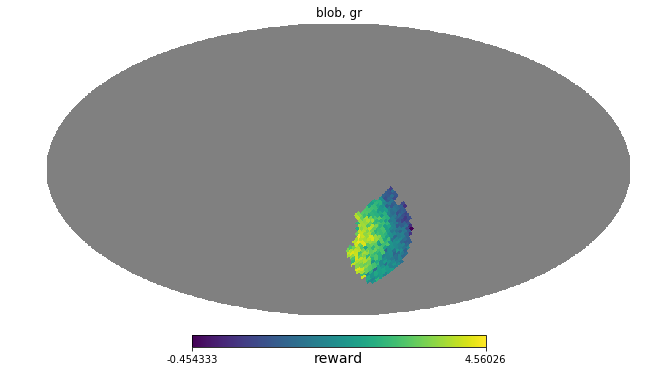

In [9]:
# The u-band isn't loaded, so the u-band blob returns -inf. and we can see the second survey is the max.
# What does that full reward look like?
hp.mollview(scheduler.survey_lists[1][1].calc_reward_function(conditions), unit='reward', title=scheduler.survey_lists[1][1].survey_note)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


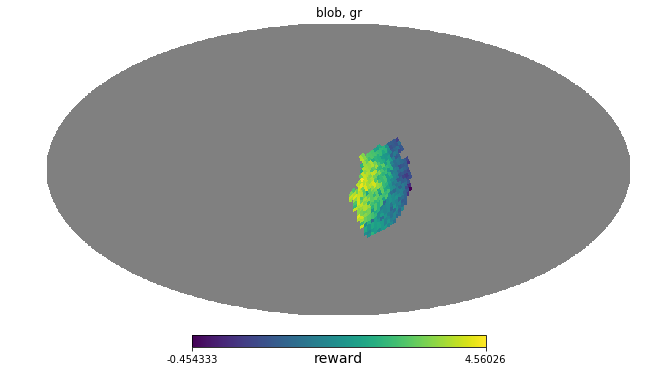

In [10]:
# We can rotate this so zenith is at the center of the projection
rot = (conditions.lmst*180./12., conditions.site.latitude)
hp.mollview(scheduler.survey_lists[1][1].calc_reward_function(conditions), unit='reward',
            title=scheduler.survey_lists[1][1].survey_note, rot=rot)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


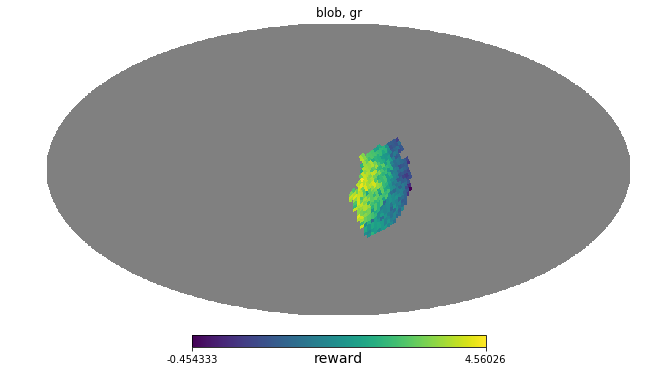

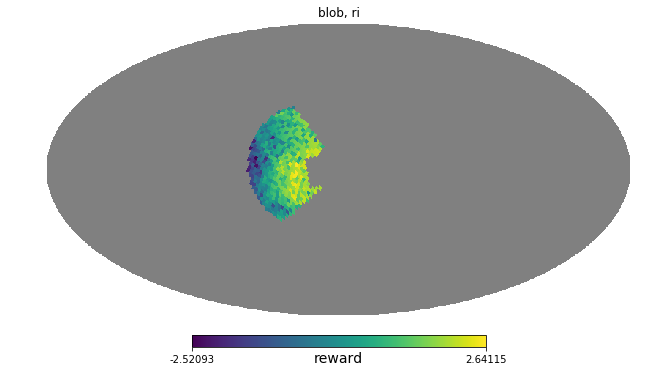

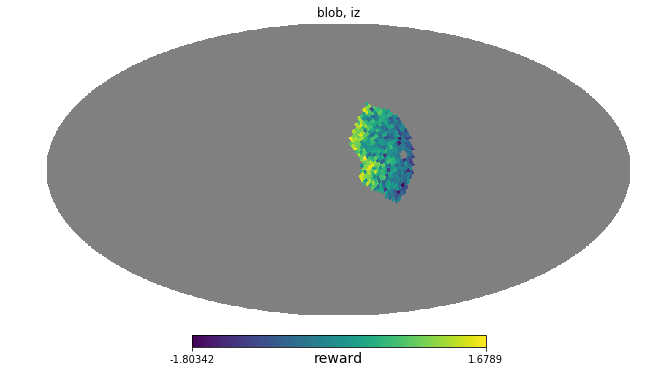

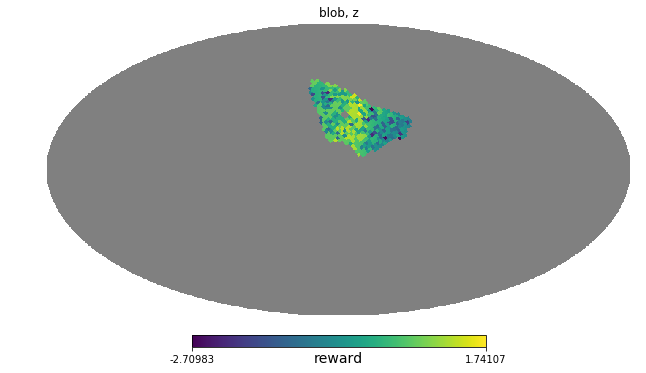

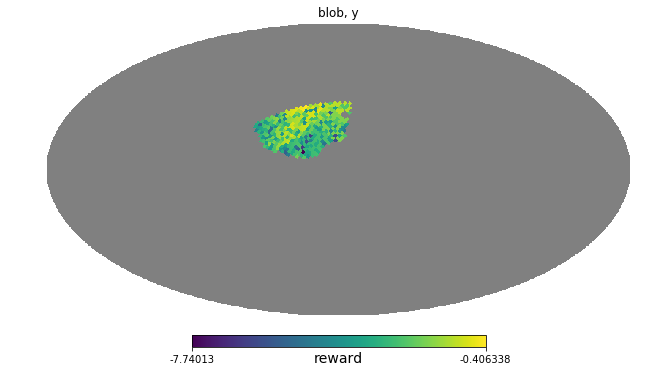

In [11]:
# We can look at all the reward functions
for i in range(len(scheduler.survey_lists[1])):
    reward_val = scheduler.survey_lists[1][i].calc_reward_function(conditions)
    if np.size(reward_val) > 1:
        hp.mollview(reward_val, unit='reward',
                    title=scheduler.survey_lists[1][i].survey_note, rot=rot)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


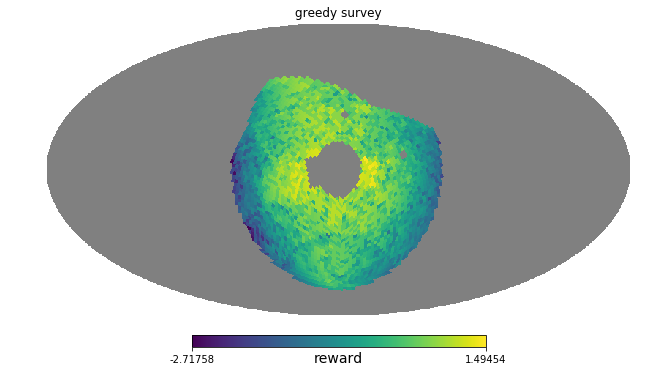

In [12]:
# We can go down one level further and see the reward function from the greedy surveys. 
hp.mollview(scheduler.survey_lists[2][1].calc_reward_function(conditions), unit='reward',
            title='greedy survey', rot=rot)

In [13]:
# Let's see the full process of how the observation list gets build
# First, the calc_reward on the blob survey finds a good block size
survey = scheduler.survey_lists[1][1]
survey._set_block_size(conditions)
print('estimate this number of observations should be in the blob', survey.nvisit_block)

estimate this number of observations should be in the blob 35


In [14]:
# next, check the basis functions to make sure the observations are feasible (this checks things like twilight)
survey._check_feasibility(conditions)

True

In [15]:
# Now, compute the basis functions and combine them multiplied by their weights to make the reward function
reward = 0
indx = np.arange(hp.nside2npix(survey.nside))
for bf, weight in zip(survey.basis_functions, survey.basis_weights):
    basis_value = bf(conditions, indx=indx)
    reward += basis_value*weight

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


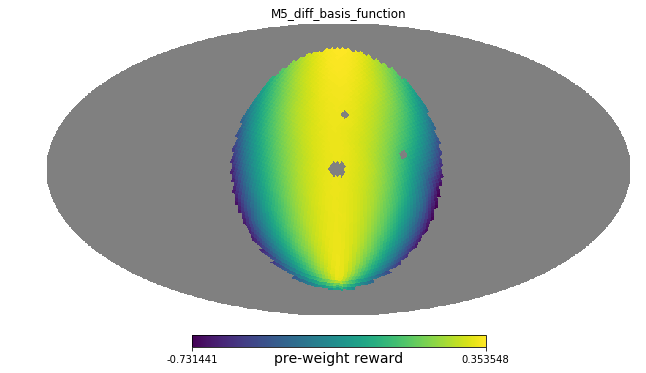

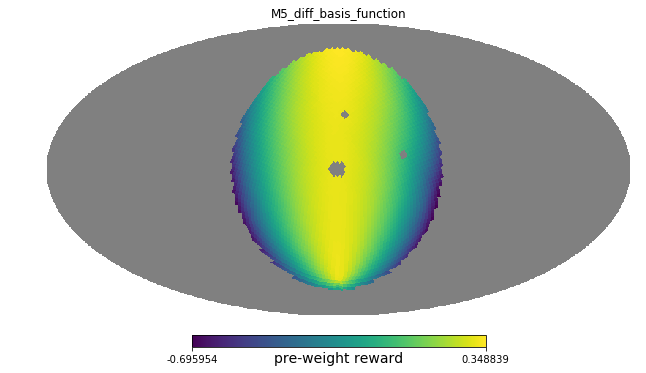

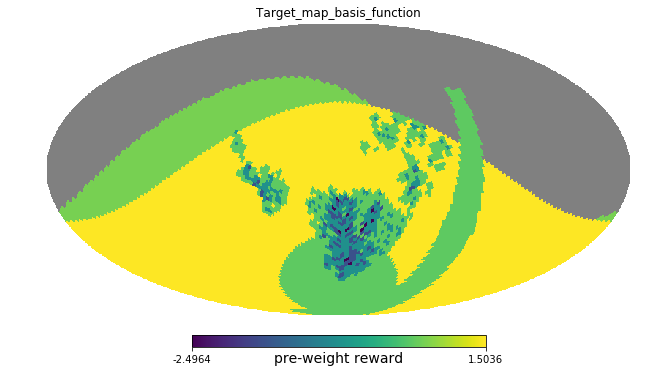

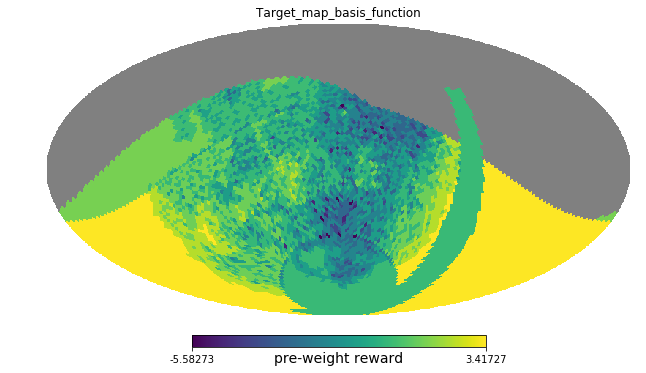

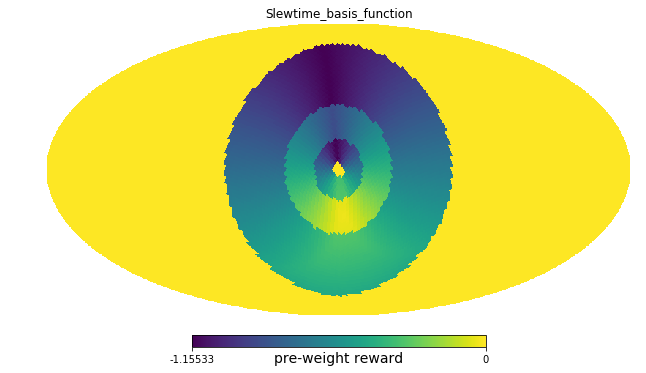

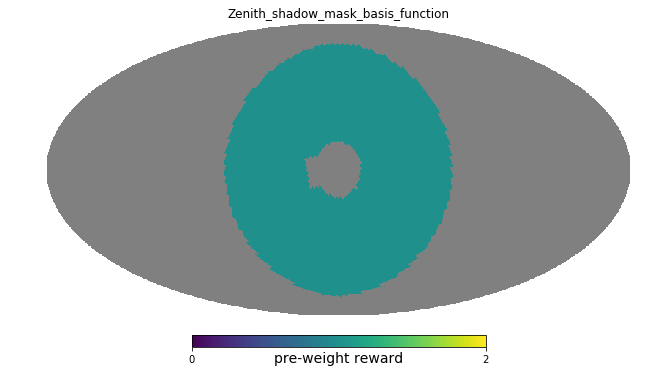

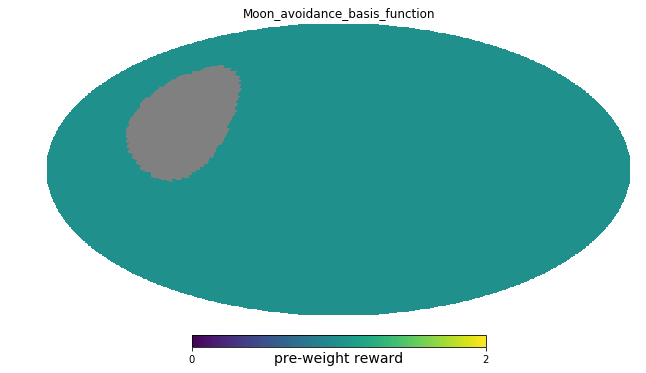

In [16]:
# Let's look at what each of the basis functions looks like

# Because this is a survey that is taking observations in two filters, it has basis functions
# for the 5-sigma depth and the survey progress in two filters

# The m5 has zenith and bright planets masked
for bf in survey.basis_functions:
    bf_val = bf(conditions, indx=indx)
    if np.size(bf_val) > 1:
        hp.mollview(bf_val, rot=rot, unit='pre-weight reward', title=bf.__class__.__name__)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


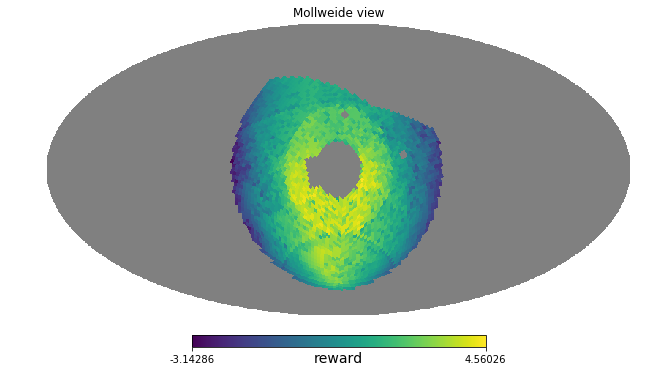

In [17]:
# And the resulting reward function
hp.mollview(reward, unit='reward', rot=rot)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


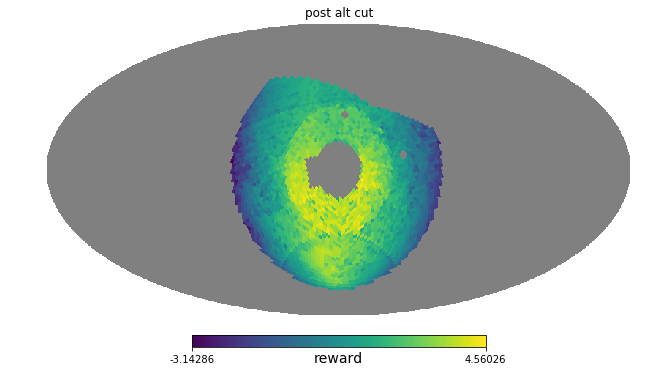

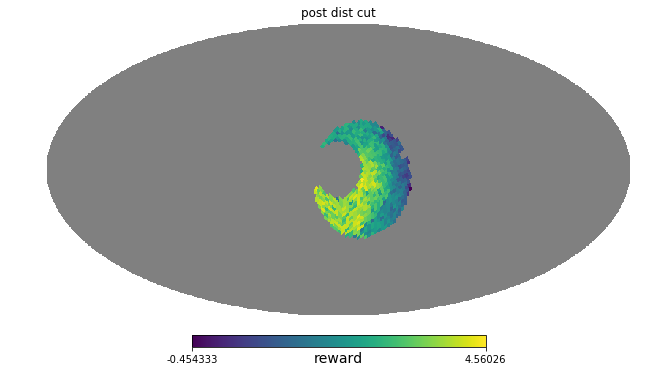

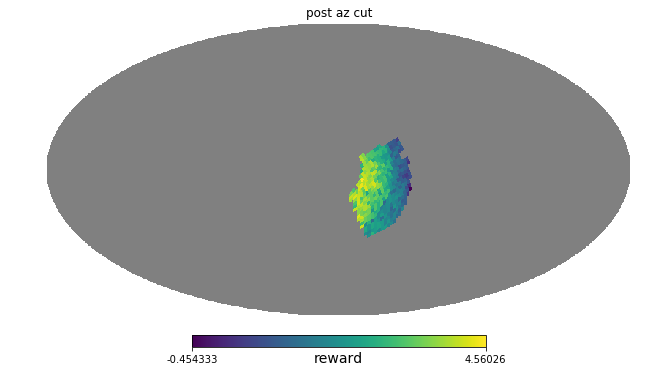

In [18]:
# Now we enter have some code that further modifies the reward function, selecting only pixels near the 
# maximum (in angular seperation and azimuthal distance)

# Altitude cut
too_high = np.where(conditions.alt > survey.alt_max)
reward[too_high] = np.nan

hp.mollview(reward, title='post alt cut', rot=rot, unit='reward')

max_hp = np.where(reward == np.nanmax(reward))[0]
peak_reward = np.min(max_hp)

dists = _angularSeparation(survey.ra[peak_reward], survey.dec[peak_reward], survey.ra, survey.dec)
out_hp = np.where(dists > survey.search_radius)
reward[out_hp] = np.nan

hp.mollview(reward, title='post dist cut', rot=rot, unit='reward')

az_centered = conditions.az - conditions.az[peak_reward]
az_centered[np.where(az_centered < 0)] += 2.*np.pi

az_out = np.where((az_centered > survey.az_range/2.) & (az_centered < 2.*np.pi-survey.az_range/2.))
reward[az_out] = np.nan

hp.mollview(reward, title='post az cut', rot=rot, unit='reward')


number of obs= 35


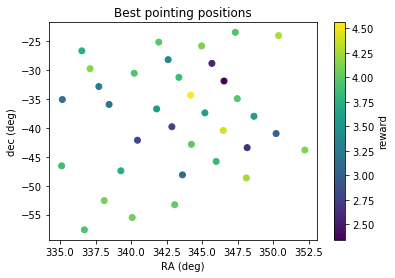

In [19]:
# Now we have our reward function, the generate_observations_rough method converts it to a list of observations

potential_hp = np.where(~np.isnan(reward) == True)
ufields, reward_by_field = int_binned_stat(survey.hp2fields[potential_hp],
                                           reward[potential_hp],
                                           statistic=np.nanmax)
# chop off any nans
not_nans = np.where(~np.isnan(reward_by_field) == True)
ufields = ufields[not_nans]
reward_by_field = reward_by_field[not_nans]

# Order by reward, take the top of the proper size
order = np.argsort(reward_by_field)
ufields = ufields[order][::-1][0:survey.nvisit_block]
survey.best_fields = ufields
reward_by_field = reward_by_field[::-1][0:survey.nvisit_block]

plt.scatter(np.degrees(survey.fields['RA'][ufields]), np.degrees(survey.fields['dec'][ufields]), c=reward_by_field)
cb = plt.colorbar()
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')
cb.set_label('reward')
plt.title('Best pointing positions')
print('number of obs=', survey.nvisit_block)

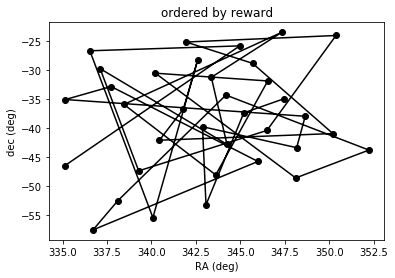

In [20]:
# Now to find an efficent path through those
plt.plot(np.degrees(survey.fields['RA'][ufields]), np.degrees(survey.fields['dec'][ufields]), 'ko-')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')
plt.title('ordered by reward')

In [21]:
pointing_alt, pointing_az = _approx_RaDec2AltAz(survey.fields['RA'][survey.best_fields],
                                                        survey.fields['dec'][survey.best_fields],
                                                        conditions.site.latitude_rad,
                                                        conditions.site.longitude_rad,
                                                        conditions.mjd,
                                                        lmst=conditions.lmst)

# Let's find a good spot to project the points to a plane
mid_alt = (np.max(pointing_alt) - np.min(pointing_alt))/2.

# Code snippet from MAF for computing mean of angle accounting for wrap around
# XXX-TODO: Maybe move this to sims_utils as a generally useful snippet.
x = np.cos(pointing_az)
y = np.sin(pointing_az)
meanx = np.mean(x)
meany = np.mean(y)
angle = np.arctan2(meany, meanx)
radius = np.sqrt(meanx**2 + meany**2)
mid_az = angle % (2.*np.pi)
if radius < 0.1:
    mid_az = np.pi

# Project the alt,az coordinates to a plane. Could consider scaling things to represent
# time between points rather than angular distance.
pointing_x, pointing_y = gnomonic_project_toxy(pointing_az, pointing_alt, mid_az, mid_alt)
# Now I have a bunch of x,y pointings. Drop into TSP solver to get an effiencent route
towns = np.vstack((pointing_x, pointing_y)).T
# Leaving optimize=False for speed. The optimization step doesn't usually improve much.
better_order = tsp_convex(towns, optimize=False)

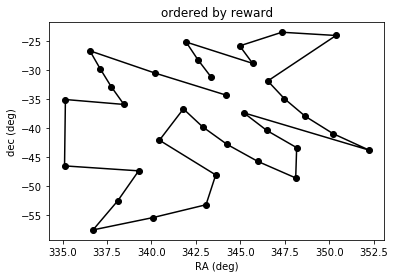

In [22]:
plt.plot(np.degrees(survey.fields['RA'][ufields][better_order]), np.degrees(survey.fields['dec'][ufields][better_order]), 'ko-')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')
plt.title('ordered by reward')

In [23]:
# Now these positions are converted into full observation objects. The list is repeated and the filter flipped for the second in the pair
# And the observation list is passed to the default detailer to set the camera rotation angle
final_observations = survey.generate_observations(conditions)

In [24]:
final_observations[0]

array([ (0,  5.99288086, -0.54584562,  59895.06463292,  59895.10065722,  30., 'g',  1.60391555, 1,  0.,  0.,  0.,  0.,  0., 0,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 'blob, gr, a', -1, 0, 1,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.)],
      dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U1'), ('rotSkyPos', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('field_id', '<i8'), ('survey_id', '<i8'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f8'), ('moonRA', '<f8'), ('moonDec', '<f8'), ('

In [25]:
final_observations = np.concatenate(final_observations)

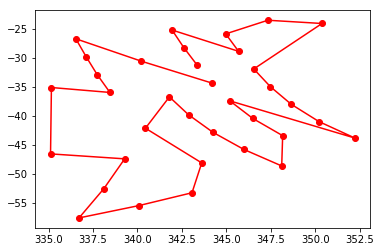

In [26]:

gobs = np.where(final_observations['filter'] == 'g')
robs = np.where(final_observations['filter'] == 'r')

plt.plot(np.degrees(final_observations['RA'][robs]), np.degrees(final_observations['dec'][robs]), 'r-o')

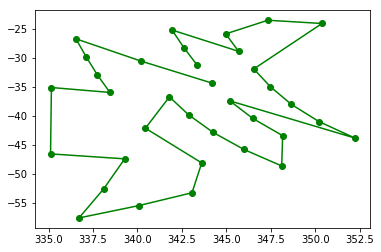

In [27]:
plt.plot(np.degrees(final_observations['RA'][gobs]), np.degrees(final_observations['dec'][gobs]), 'g-o')

In [28]:
final_observations[0]

(0,  5.99288086, -0.54584562,  59895.06463292,  59895.10065722,  30., 'g',  1.60391555, 1,  0.,  0.,  0.,  0.,  0., 0,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 'blob, gr, a', -1, 0, 1,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.)

In [29]:
final_observations[0].dtype

dtype([('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U1'), ('rotSkyPos', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('field_id', '<i8'), ('survey_id', '<i8'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f8'), ('moonRA', '<f8'), ('moonDec', '<f8'), ('moonDist', '<f8'), ('solarElong', '<f8'), ('moonPhase', '<f8')])

Because it's an important factor, let's take a closer look at the m5-diff basis function, and what it looks like in different filters.

In [30]:
survey_u = scheduler.survey_lists[1][0]
survey_gr = scheduler.survey_lists[1][1]

In [32]:
survey_u.basis_functions[0]

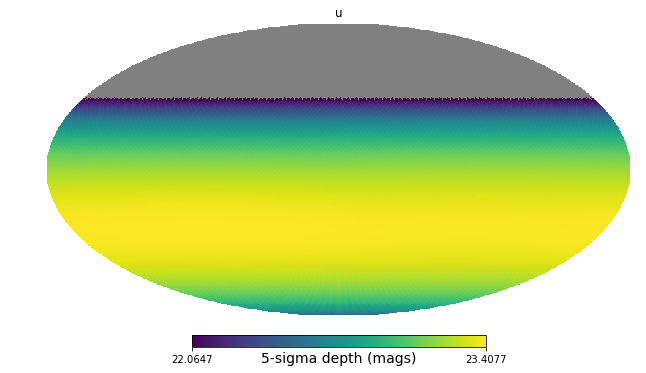

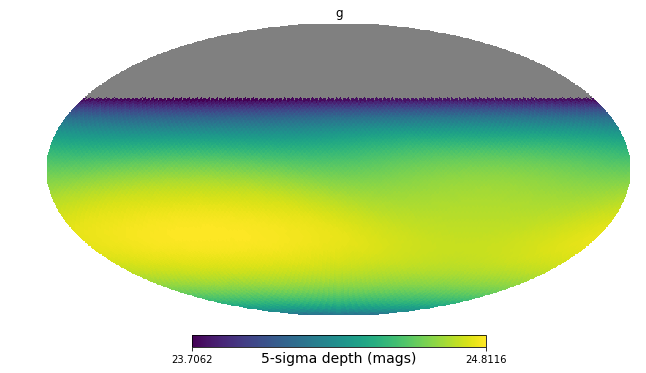

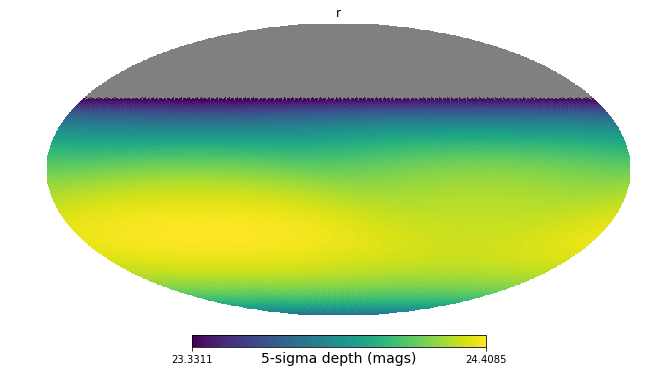

In [38]:
# Maps of the 5-sigma limiting depth when a healpixel is on the meridian, in dark time, with good seeing
dm = survey_u.basis_functions[0].dark_map
dm[np.where(dm ==0)] = hp.UNSEEN
hp.mollview(dm, unit='ideal 5-sigma depth (mags)', title='u')

dm = survey_gr.basis_functions[0].dark_map
dm[np.where(dm ==0)] = hp.UNSEEN
hp.mollview(dm, unit='ideal 5-sigma depth (mags)', title='g')

dm = survey_gr.basis_functions[1].dark_map
dm[np.where(dm ==0)] = hp.UNSEEN
hp.mollview(dm, unit='ideal 5-sigma depth (mags)', title='r')


/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


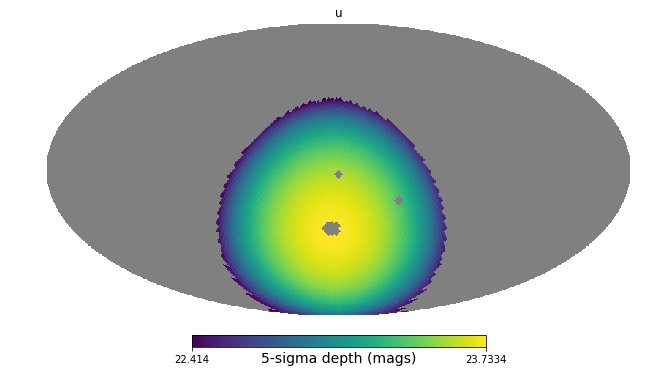

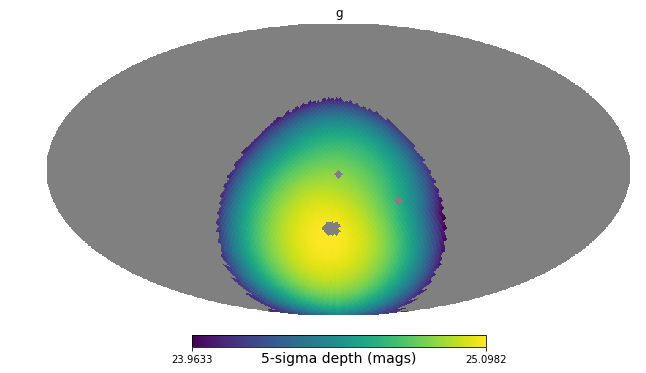

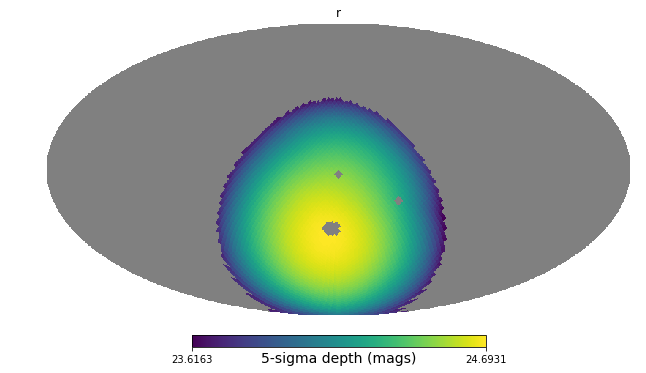

In [41]:
for filtername in 'ugr':
    hp.mollview(conditions.M5Depth[filtername], title=filtername, unit='5-sigma depth (mags)')

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


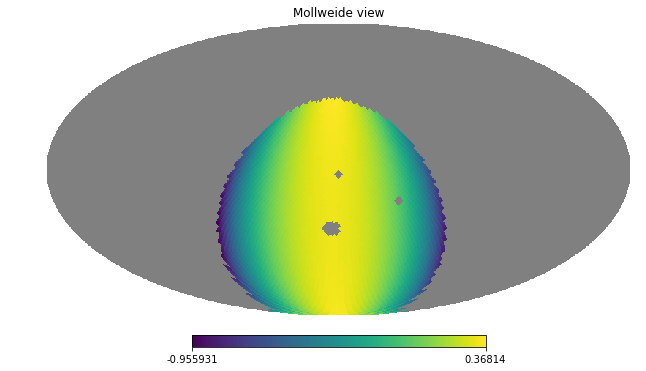

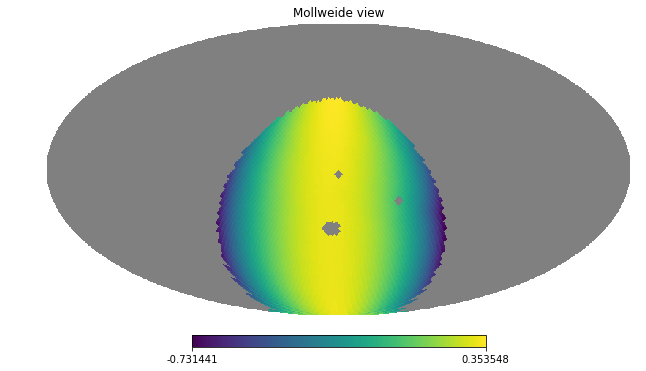

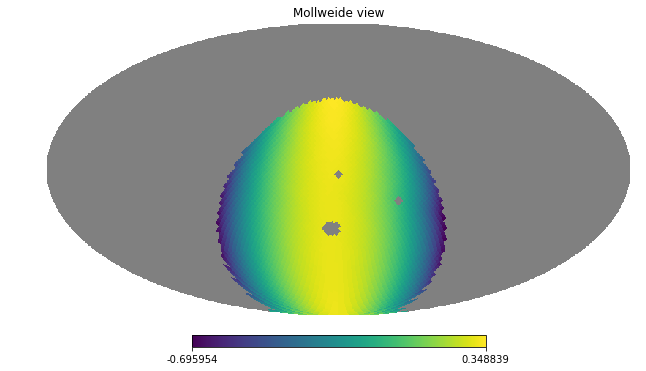

In [50]:
hp.mollview(survey_u.basis_functions[0](conditions))
hp.mollview(survey_gr.basis_functions[0](conditions))
hp.mollview(survey_gr.basis_functions[1](conditions))


0.6208250083789153